# Main

___
## Imports

In [1]:
from utils.load import load_data, load_split_dataset
from utils.explore import get_descriptive_statistics, explore_dataset
from utils.split import split_and_save_data
from utils.explore import visualize_image, get_captions

___
## Global Variables

In [2]:
image_folder = "data/Images"
image_folder_homogeneous = "data/Images_homogeneous"
captions_file = "data/captions.txt"
split_data = "data/split_dataset"

___
## Explore Dataset

Valid if the dataset has already been loaded into your `data` folder.

In [ ]:
get_descriptive_statistics(image_folder)

In [ ]:
explore_dataset(image_folder, captions_file)

___
## Load Data

In [3]:
image_arrays, image_captions = load_data(image_folder_homogeneous, captions_file)

In [4]:
print(type(image_arrays), type(image_captions))

<class 'dict'> <class 'dict'>


___
## Split Dataset

In [5]:
train_data, val_data, test_data, train_captions, val_captions, test_captions = split_and_save_data(image_arrays, image_captions, save_folderpath=split_data)

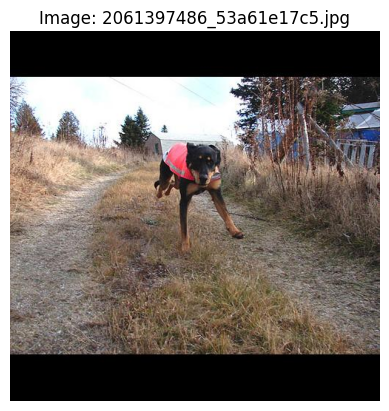

['A black dog with brown markings wearing a red vest trots down a path .', 'A brown and black dog is running along a grassy path wearing a red jacket .', 'A dog with a reflective garmet running down a rural road', 'Brown and black dog with red and white jacket run on road in rural area .', 'Dog with a red cape running on a dirt road .']


In [8]:
i = 128
visualize_image(train_data, i)
print(
    get_captions(train_captions, i)
)